# HRNN Data Preprocessing Pipeline

In [1]:
# standard imports
import os
import random

# 3d-party imports
import h5py
import glob
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# ML
import torch
import torch.nn as nn
from torch.utils.data import Dataset

plt.rcParams[
    "figure.facecolor"
] = "w"  # force white background on plots when using dark mode in JupyterLab

TIME_STEP = 1
CLASSNAME = {0: 'ballistic', 1: 'hgv', 2: 'hcm'}
CLASSTYPE = {'ballistic': 0, 'hgv': 1, 'hcm': 2}

# Prepare data
## Load and examine data

In [2]:
dset = pd.HDFStore('data/ballistic_batch_1000_nopad.h5', 'r')
print(dset.info())

<class 'pandas.io.pytables.HDFStore'>
File path: data/ballistic_batch_1000_nopad.h5
/ballistic_raw/BALLISTIC_1               frame        (shape->[290,8])
/ballistic_raw/BALLISTIC_10              frame        (shape->[193,8])
/ballistic_raw/BALLISTIC_100             frame        (shape->[378,8])
/ballistic_raw/BALLISTIC_1000            frame        (shape->[340,8])
/ballistic_raw/BALLISTIC_101             frame        (shape->[361,8])
/ballistic_raw/BALLISTIC_102             frame        (shape->[297,8])
/ballistic_raw/BALLISTIC_103             frame        (shape->[242,8])
/ballistic_raw/BALLISTIC_104             frame        (shape->[170,8])
/ballistic_raw/BALLISTIC_105             frame        (shape->[303,8])
/ballistic_raw/BALLISTIC_106             frame        (shape->[199,8])
/ballistic_raw/BALLISTIC_107             frame        (shape->[180,8])
/ballistic_raw/BALLISTIC_108             frame        (shape->[179,8])
/ballistic_raw/BALLISTIC_109             frame        (shape->[2

In [24]:
np.array(dset[dset.keys()[0]])

array([[ 5.17297529e+06,  3.48921589e+06,  1.31741812e+06, ...,
         4.15823382e+02,  7.50000000e+01,  0.00000000e+00],
       [ 5.17448943e+06,  3.49023702e+06,  1.31780614e+06, ...,
         3.63011072e+02,  1.94204703e+03,  1.00000000e+00],
       [ 5.17583004e+06,  3.49114071e+06,  1.31814897e+06, ...,
         3.24739223e+02,  3.59474916e+03,  2.00000000e+00],
       ...,
       [ 5.22824911e+06,  3.47372638e+06,  1.13441573e+06, ...,
        -3.40071517e+02,  1.27787482e+03,  2.87000000e+02],
       [ 5.22791150e+06,  3.47343630e+06,  1.13408483e+06, ...,
        -3.22009908e+02,  7.84042509e+02,  2.88000000e+02],
       [ 5.22758543e+06,  3.47315774e+06,  1.13377120e+06, ...,
        -3.05483863e+02,  3.09050684e+02,  2.89000000e+02]])

## Train-Val-Test split keys

In [3]:
def train_val_test_split(data, tts = (0.7, 0.1, 0.2), shuffle=False):
    '''Split data into train, validation and test sets according to `tts` tuple
    
    By default, tts = (train, val, test) = (0.7, 0.1, 0.2)
    '''
    assert sum(tts) == 1
    
    if shuffle:
        data = np.random.shuffle(data)
    
    h = len(data)
    train = data[:int(h * tts[0])]
    val = data[int(h * tts[0]) : int(h * np.round(tts[0] + tts[1], 4))]
    test = data[int(h * np.round(tts[0] + tts[1], 4)) : int(h * sum(tts))]

    return train, val, test

In [4]:
# Train-val-test split data
data_keys = sorted([key for key in dset.keys() if 'raw' in key])
# Test data       = 20% of total keys
# Validation data = 10% of total keys
# Train data      = 70% of total keys
train_keys, val_keys, test_keys = train_val_test_split(
    data_keys, (0.7, 0.1, 0.2), shuffle=False)

print(f'Train keys: {len(train_keys):>5} -> {len(train_keys)/len(data_keys) * 100}%')
print(f'Valid keys: {len(val_keys):>5} -> {len(val_keys)/len(data_keys) * 100}%')
print(f'Test keys:  {len(test_keys):>5} -> {len(test_keys)/len(data_keys) * 100}%')

Train keys:   700 -> 70.0%
Valid keys:   100 -> 10.0%
Test keys:    200 -> 20.0%


## Invertible trajectory pre-processing transform

In [5]:
class RelativeTrajectory():
    def __init__(self, df, diff=False, ref_point=20):

        self.diff = diff
        self.ref_point = ref_point
        
        data = np.array(df.drop('t', 1))
        
        # Remember first state
        self.start_state = data[0].copy()
        
        # Make changes relative to the start state
        data -= self.start_state
        
        # Rotate coordinate system around Z axis, 
        # so X` axis will pass through the 20'th point
        # and Y` axis will represent deviation

        ## Calculate angle of rotation: arctan(y_r / x_r), where r is ref_point
        assert data.shape[0] >= ref_point
        self.theta = np.arctan(data[ref_point][1] / data[ref_point][0])

        ## Rotation matrix for XY plane around Z axis
        ## Perform rotation for coordinates
        data[:, :3] = self.rotate_Z(data[:, :3], self.theta)

        ## Perform rotation for velocities
        data[:, 3:6] = self.rotate_Z(data[:, 3:6], self.theta)

        # Scale data to kilometers
        data /= 1000

        self.first_diff_elem = None
        if diff:
            self.first_diff_elem = data[0].copy()
            data = np.diff(data, axis=0)    
        
        self.data = data
        
    def restore(self, columns, ts=1, config=None):
        
        assert ts > 0
        
        if config:
            self.set_info(config)
        
        # Restore diff data
        if self.diff:
            data = np.r_[np.expand_dims(self.first_diff_elem, 0), np.cumsum(self.data, axis=0)]
        else:         
            data = self.data.copy()
        
        # Scale data from km back to meters
        data *= 1000
        
        ## Rotation matrix for XY plane around Z axis
        ## Perform rotation for coordinates
        data[:, 0:3] = self.rotate_Z(data[:, 0:3], -self.theta)

        ## Perform rotation for velocities
        data[:, 3:6] = self.rotate_Z(data[:, 3:6], -self.theta)
        
        # Make changes absolute
        data += self.start_state

        # Restore Pandas.DataFrame format
        t = np.arange(0, data.shape[0], ts)
        data = np.c_[data, t] 
        data = pd.DataFrame(data, columns=columns)
        
        return data
        
    @staticmethod
    def rotate_Z(data, theta):
        """Rotate data around the Z axis using matrix R"""
        
        R = np.array([
            [np.cos(theta), -np.sin(theta), 0],
            [np.sin(theta),  np.cos(theta), 0],
            [            0,              0, 1]
        ])
        return data @ R.T
    
    def info(self):
        return {
            'ref_point' : self.ref_point,
            'diff' : self.diff,
            'start_state' : self.start_state,
            'first_diff_elem' : self.first_diff_elem,
            'theta' : self.theta
        }
    
    def set_info(self, config):
        self.ref_point = config['ref_point']
        self.diff = config['diff']
        self.start_point = config['start_point']
        self.first_diff_elem = config['first_diff_elem']
        self.theta = config['theta']

In [6]:
from sklearn.preprocessing import StandardScaler

# Calculate mean and variance over all training set 
print('Calculating mean and variance over all training data...')
scaler = StandardScaler()
means = []
for train_key in tqdm(train_keys):
    traj = RelativeTrajectory(dset[train_key])
    means.append(traj.data.mean(axis=0))

scaler.fit(np.array(means))

Calculating mean and variance over all training data...


StandardScaler()

In [7]:
print('Mean:')
pd.DataFrame([scaler.mean_], columns=dset[train_key].columns[:-1])

Mean:


,coord_x,coord_y,coord_z,vel_x,vel_y,vel_z,alt
0,40.26699,52.465953,-61.267248,-0.583445,-1.75384,-0.963626,50.522303


In [8]:
print('Variance:')
pd.DataFrame([scaler.var_], columns=dset[train_key].columns[:-1])

Variance:


,coord_x,coord_y,coord_z,vel_x,vel_y,vel_z,alt
0,530.135423,1136.609617,685.637665,0.001714,0.000046,0.016432,1184.550669


## Preprocess data for training

In [9]:
def plot_trajectory(data, label=''):
    # display some trajectories for visual representation
    fig = plt.figure(figsize=plt.figaspect(1))
    ax = fig.add_subplot(111, projection='3d')
    data = np.array(data)
    colors = np.arange(data.shape[0])
    
    # Plot:
    ax.scatter3D(data[:, 0], data[:, 1], data[:, 2], c=colors, cmap='plasma');
    ax.set_xlabel('X (10^6 m)')
    ax.set_ylabel('Y (10^6 m)')
    ax.set_zlabel('Z (10^6 m)')
    ax.set_title(CLASSNAME.get(label, label))
    
    plt.show()

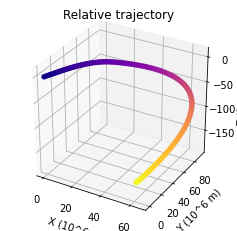

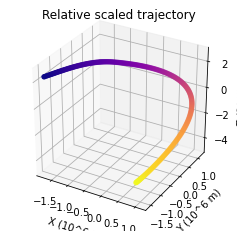

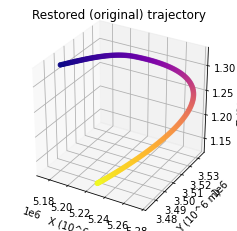

In [10]:
%matplotlib inline
for i in range(1):
    rt = RelativeTrajectory(dset[train_keys[i]], diff=False)
    plot_trajectory(rt.data, 'Relative trajectory')
    plot_trajectory(scaler.transform(rt.data), 'Relative scaled trajectory')
    plot_trajectory(rt.restore(dset[train_keys[i]].columns), 'Restored (original) trajectory')

In [25]:
rt

In [11]:
def get_strided_data_clust(dset, keys, variables=3, residuals=True, gt_size=8, horizon=12, step=1, diff=False, verbose=False):
    '''Return list with parts of trajectories and their residuals.
    
    Arguments:
        dset -- h5py Data set with trajectory data
        keys -- keys for extracting data from `dset`
        
    Keyword arguments:
        variables -- (default: 3) how many variables to extract:
                     3 for XYZ -- coordinates,
                     6 for XYZUVW -- coordinates and speeds,
                     7 for XYZUVWH -- coords, speeds and altitude
        
        residuals -- (default: True) if True, residuals of trajectory will 
                     be concatenated, such that, in case of 3 variables: 
                     [[X1, Y1, Z1],      [[X1, Y1, Z1,     0,     0,     0],
                      [X2, Y2, Z2],  -->  [X2, Y2, Z2, X2-X1, Y2-Y1, Z2-Z1],
                      [X3, Y3, Z3]]       [X3, Y3, Z3, X3-X2, Y3-Y2, Z3-Z2]]
        
        gt_size -- how many trajectory points are to be observed
        horizon -- how many trajectory points are to be predicted
        step -- (default: 1) 
                if 1, every row from the `dset` will be processed,
                if >1, some rows will be skipped accordingly.
        diff -- (default: False) toggle extract differentiated relative trajectories
    '''
    
    assert variables in [3, 6, 7]
    
    # Create list with parts of trajectories,
    # each element has (gt_size+horizon) trajectory points
    data_seqs = []
    
    # Set of configs for each trajectory. 
    configs = {}
    
    # List of trajectory indices 
    # (to which trajectory this traj_elem belongs to)
    traj_ids = []
    
    # Collect trajectories, preprocess and 
    # split them into trajectory parts
    for k in tqdm(range(len(keys)), disable=1-verbose, desc='Collecting strided data'):
        # Get relative trajectory from the dataset
        rt = RelativeTrajectory(dset[keys[k]], diff=diff)
        configs[k] = rt.info()  # save for future restoration

        # Collect list of trajectory parts from `rt` 
        # using time window [gt_size + horizon] and time shift `step`
        for i in range(1 + (rt.data.shape[0] - gt_size - horizon) // step):
            data_seqs.append([rt.data[i*step : i*step + gt_size + horizon, :variables]])
            traj_ids.append(k)
    
    # Collect all data seqs into one huge dataset 
    # of shape [? , gt_size + horizon, variables]
    data_seqs_all = np.stack(data_seqs).squeeze()
    traj_ids_all = np.stack(traj_ids)

    # Calculate mean and std over all data
    data_mean = data_seqs_all.mean((0, 1))
    data_std = data_seqs_all.std((0, 1))
    res_mean = np.zeros(variables)
    res_std = np.ones(variables)
    
    if residuals:
        # Compute and add columns with residuals
        # note that the first row should be zeros
        # (if we have 8 measurements, we only can have 7 residuals)
        res = np.concatenate((
            np.zeros((data_seqs_all.shape[0], 1, variables)),
            data_seqs_all[:, 1:, :] - data_seqs_all[:, :-1, :]
        ), 1)
    
        res_mean = res[:, 1:].mean((0, 1))
        res_std = res[:, 1:].std((0, 1))
    
        data_seqs_all = np.concatenate((data_seqs_all, res), 2)
    
    stats = {
        'data_mean': data_mean,
        'data_std': data_std,
        'res_mean': res_mean,
        'res_std': res_std
    }
    
    if verbose:
        with np.printoptions(precision=3):
            print(f'Total trajectory parts: {data_seqs_all.shape[0]}')
            print(f'Each: {gt_size} observed + {horizon} horizon = {gt_size+horizon} points in total')
            if residuals:
                print(f'Each point contains {int(data_seqs_all.shape[-1]/2)} variables and {int(data_seqs_all.shape[-1]/2)} residuals')
            else:
                print(f'Each point contains {data_seqs_all.shape[-1]} variables')

            print('Data mean:', stats['data_mean'],
                  'Data std:', stats['data_std'], 
                  sep='\n')
            if residuals:
                print('Residuals mean:', stats['res_mean'],
                      'Residuals std:', stats['res_std'], 
                      sep='\n')
    return (
        data_seqs_all.squeeze()[:, :gt_size], # src sequences
        data_seqs_all.squeeze()[:, gt_size:], # tgt sequences
        configs,
        stats,
        traj_ids_all
    )

In [12]:
inp, out, configs, stats, traj_ids = get_strided_data_clust(
    dset,
    train_keys,
    gt_size=8,
    horizon=12,
    step=1,
    variables=7,
    residuals=True,
    diff=False,
    verbose=True
)


Total trajectory parts: 170667
Each: 8 observed + 12 horizon = 20 points in total
Each point contains 7 variables and 7 residuals
Data mean:
[ 48.576  65.975 -68.196  -0.572  -1.774  -1.038  64.562]
Data std:
[32.327 46.9   65.894  0.253  0.637  0.317 49.332]
Residuals mean:
[ 0.174  0.034 -0.622 -0.002 -0.006 -0.002 -0.024]
Residuals std:
[0.253 0.637 0.317 0.004 0.01  0.01  0.705]


In [13]:
class TrajectoryDataset(torch.utils.data.Dataset):
    def __init__(self, data, name, variables=3, configs=None, stats=None):
        super().__init__()
    
        self.data = data
        self.name = name
        self.variables = variables
        self.configs = configs
        self.stats = stats
        
    def __len__(self):
        return self.data['src'].shape[0]
    
    def __getitem__(self, index):
        
        ret =  {
            'src': torch.Tensor(self.data['src'][index]),
            'tgt': torch.Tensor(self.data['tgt'][index]),
            'traj_id': self.data['traj_ids'][index],
        }
        return ret

In [14]:
def create_dataset(dset, keys, name, variables=3, residuals=True, gt_size=8, horizon=12, step=1, diff=False, train=True, scaler=None, verbose=False):
    """Create TrajectoryDataset for training NNs.

    Arguments:
        dset -- h5py dataset object
        keys -- list of strings: keys for extracting data from `dset`
        name -- name of the TrajectoryDataset

    Keyword arguments:
        variables -- (default: 3) how many variables to extract:
                     3 for XYZ -- coordinates,
                     6 for XYZUVW -- coordinates and speeds,
                     7 for XYZUVWH -- coords, speeds and altitude

        residuals -- (default: True) if True, residuals of trajectory will 
                     be concatenated, such that, in case of 3 variables: 
                     [[X1, Y1, Z1],      [[X1, Y1, Z1,     0,     0,     0],
                      [X2, Y2, Z2],  -->  [X2, Y2, Z2, X2-X1, Y2-Y1, Z2-Z1],
                      [X3, Y3, Z3]]       [X3, Y3, Z3, X3-X2, Y3-Y2, Z3-Z2]]

        gt_size -- how many points are observed (model input)
        horizon -- how many points the model tries to predict into the future
        step -- stride step for data
        diff -- toggle differentiate trajectories
        train -- this data will be used for training
        scaler -- custom scaler, so data will have zero mean and unit variance
        verbose -- toggle print info to the terminal
        
    Note:
        If `train == True`, the scaler will fit on the collected data and
        then returned as the TrajectoryDataset.scaler attribute
        
        If 'train == False', this function will look for scaler from the 
        arguments, then use it to scale collected data for evaluation.
    """
    if verbose:
        print(f"Loading dataset in {'train' if train else 'evaluation'} mode...")

    inp, out, configs, stats, traj_ids = get_strided_data_clust(
        dset, keys, variables, residuals, gt_size, horizon, step, diff, verbose)

    data = {
        'src': inp,
        'tgt': out, 
        'traj_ids': traj_ids
    }

    return TrajectoryDataset(data, name, variables, configs, stats)

In [15]:
td = create_dataset(
    dset,
    train_keys[:10],
    name='train',
    variables=3,
    residuals=True,
    gt_size=8,
    horizon=12,
    train=True,
    verbose=True
)

Loading dataset in train mode...



Total trajectory parts: 2583
Each: 8 observed + 12 horizon = 20 points in total
Each point contains 3 variables and 3 residuals
Data mean:
[ 51.336  69.519 -72.682]
Data std:
[29.301 41.153 66.997]
Residuals mean:
[ 0.183  0.037 -0.648]
Residuals std:
[0.258 0.656 0.323]


In [16]:
train_dl = torch.utils.data.DataLoader(
    td,
    batch_size=2,
    shuffle=False,
    num_workers=0)

In [17]:
for id_b, batch in enumerate(train_dl):
    
    print(batch)
    break

{'src': tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.6965,  1.6882,  0.3880,  0.6965,  1.6882,  0.3880],
         [ 1.3134,  3.1827,  0.7308,  0.6169,  1.4944,  0.3428],
         [ 1.8738,  4.5390,  1.0409,  0.5604,  1.3563,  0.3100],
         [ 2.3938,  5.7961,  1.3266,  0.5199,  1.2571,  0.2857],
         [ 2.8844,  6.9807,  1.5938,  0.4906,  1.1846,  0.2672],
         [ 3.3535,  8.1115,  1.8462,  0.4691,  1.1308,  0.2524],
         [ 3.8068,  9.2020,  2.0864,  0.4533,  1.0905,  0.2403]],

        [[ 0.6965,  1.6882,  0.3880,  0.0000,  0.0000,  0.0000],
         [ 1.3134,  3.1827,  0.7308,  0.6169,  1.4944,  0.3428],
         [ 1.8738,  4.5390,  1.0409,  0.5604,  1.3563,  0.3100],
         [ 2.3938,  5.7961,  1.3266,  0.5199,  1.2571,  0.2857],
         [ 2.8844,  6.9807,  1.5938,  0.4906,  1.1846,  0.2672],
         [ 3.3535,  8.1115,  1.8462,  0.4691,  1.1308,  0.2524],
         [ 3.8068,  9.2020,  2.0864,  0.4533,  1.0905,  0.2403],
         [ 4.24

In [18]:
td.stats

{'data_mean': array([ 51.33600042,  69.51910868, -72.68229755]),
 'data_std': array([29.3008081 , 41.1528042 , 66.99735873]),
 'res_mean': array([ 0.18251633,  0.03739924, -0.64791845]),
 'res_std': array([0.25823571, 0.65554548, 0.32269679])}